In [1]:
import $ivy.`org.apache.spark::spark-sql:2.4.3`


import org.apache.spark.sql._
import org.apache.spark.sql.functions._


//Reducir numero logs
import org.apache.log4j.{Level, Logger}
Logger.getLogger("org").setLevel(Level.OFF)


//For adding extra dependenies
import $ivy.`org.typelevel::cats-core:1.6.0`

//Plotly
import $ivy.`org.plotly-scala::plotly-almond:0.7.1`
import plotly._, plotly.element._, plotly.layout._, plotly.Almond._

import $ivy.$                                  



import org.apache.spark.sql._

import org.apache.spark.sql.functions._


//Reducir numero logs

import org.apache.log4j.{Level, Logger}

import $ivy.$                               

//Plotly

import $ivy.$                                      

import plotly._, plotly.element._, plotly.layout._, plotly.Almond._

### Inicio Spark Session y Algunos métodos para descargar los datos

In [2]:
//Iniciamos session de Spark
val spark = {
  NotebookSparkSession.builder()
     .master("local[*]")
    .config("spark.executor.instances", "4") // Número de ejecutores
    .config("spark.executor.memory", "4g") // Memoria por ejecutor
    .config("spark.executor.cores", "2") // Núcleos por ejecutor
    .config("spark.driver.memory", "4g") // Memoria del driver
    .config("spark.sql.shuffle.partitions", "8") // Número de particiones para operaciones de shuffle
    .getOrCreate()
}
import spark.implicits._

Loading spark-stubs
Getting spark JARs
Creating SparkSession


Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties


Spark UI

spark: SparkSession = org.apache.spark.sql.SparkSession@3fc57c18
import spark.implicits._

# Carga de datos
Datos diarios del balance electrico a nivel nacional

In [3]:
val filePath = "data/ModelosCsv/datasetTotalBalanceNacional11-24.csv/part-00000-9bd6e093-43c2-4d8e-9fbe-7c1742d00627-c000.csv"
val dataFrameBalance: DataFrame = spark.read
  .option("header", "true") // Si el archivo tiene un encabezado
  .option("inferSchema", "true") // Para inferir automáticamente el esquema
  .csv(filePath)

csv at cmd2.sc:5

1 / 1

csv at cmd2.sc:5

3 / 3

filePath: String = "data/ModelosCsv/datasetTotalBalanceNacional11-24.csv/part-00000-9bd6e093-43c2-4d8e-9fbe-7c1742d00627-c000.csv"
dataFrameBalance: DataFrame = [Familia: string, Tipo: string ... 6 more fields]

In [4]:
org.apache.spark.sql.catalyst.encoders.OuterScopes.addOuterScope(this);
case class Balance(
    Familia: String,
    Tipo: String,
    FechaCompleta: java.sql.Timestamp,
    Valor: Double,
    Porcentaje: Double,
    Dia: String,
    Hora: String,
    BajasEmisiones: Boolean
)

val dataSetBalance: Dataset[Balance] = dataFrameBalance.as[Balance]

defined class Balance
dataSetBalance: Dataset[Balance] = [Familia: string, Tipo: string ... 6 more fields]

In [5]:
//Podemos aplicar map
dataSetBalance.map(b => b.copy(Valor = b.Valor * 1000)).show()

show at cmd4.sc:1

1 / 1

+---------+----------+-------------------+------------+-------------------+-------------------+--------+--------------+
|  Familia|      Tipo|      FechaCompleta|       Valor|         Porcentaje|                Dia|    Hora|BajasEmisiones|
+---------+----------+-------------------+------------+-------------------+-------------------+--------+--------------+
|Renovable|Hidráulica|2010-12-31 23:00:00|1.32922642E8|  0.730243950800116|2010-12-31 00:00:00|23:00:00|          true|
|Renovable|Hidráulica|2011-01-01 23:00:00| 1.2247516E8|0.46094258667156873|2011-01-01 00:00:00|23:00:00|          true|
|Renovable|Hidráulica|2011-01-02 23:00:00|1.46861638E8| 0.5886483989680635|2011-01-02 00:00:00|23:00:00|          true|
|Renovable|Hidráulica|2011-01-03 23:00:00|1.45876053E8| 0.5383243444180309|2011-01-03 00:00:00|23:00:00|          true|
|Renovable|Hidráulica|2011-01-04 23:00:00|1.58946134E8| 0.4184631870402314|2011-01-04 00:00:00|23:00:00|          true|
|Renovable|Hidráulica|2011-01-05 23:00:0

### Gráfico evolución anual distintos tipos de energia

collect at cmd19.sc:12

3 / 3

collect at cmd19.sc:12

8 / 8

collect at cmd19.sc:12

8 / 8

collect at cmd19.sc:12

8 / 8

collect at cmd19.sc:13

3 / 3

collect at cmd19.sc:13

8 / 8

collect at cmd19.sc:13

8 / 8

collect at cmd19.sc:13

8 / 8

collect at cmd19.sc:13

3 / 3

collect at cmd19.sc:13

8 / 8

collect at cmd19.sc:13

8 / 8

collect at cmd19.sc:13

8 / 8

collect at cmd19.sc:13

3 / 3

collect at cmd19.sc:13

8 / 8

collect at cmd19.sc:13

8 / 8

collect at cmd19.sc:13

8 / 8

collect at cmd19.sc:13

3 / 3

collect at cmd19.sc:13

8 / 8

collect at cmd19.sc:13

8 / 8

collect at cmd19.sc:13

8 / 8

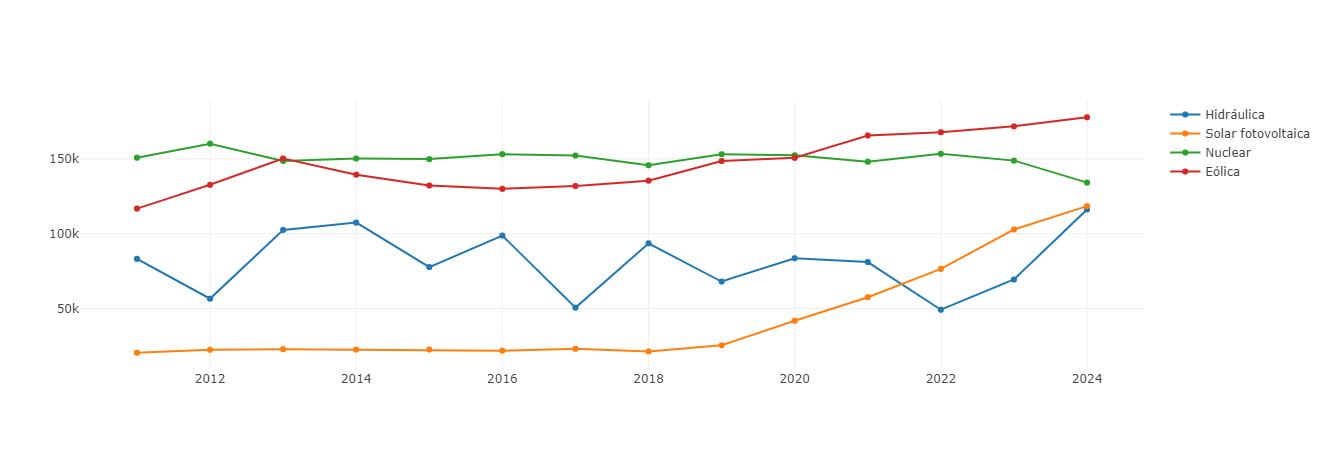

defined function AnalisisEnergiasAnual
EnergiasParaAnalizar: Seq[String] = List(
  "Hidr\u00e1ulica",
  "Solar fotovoltaica",
  "Nuclear",
  "E\u00f3lica"
)

In [20]:
def AnalisisEnergiasAnual(listaEnergias: Seq[String], dataFrameBalance: DataFrame): Unit = {
  // Agrupar y calcular la media para datos renovables
  def calcularMediaAnual(df: DataFrame, tipo: String): DataFrame = {
    df.filter(col("Tipo") === tipo)
      .filter(date_format(col("FechaCompleta"), "yyyy") =!= "2010")  
      .groupBy(date_format(col("FechaCompleta"), "yyyy").as("Año"))
      .agg(avg("Valor").as("ValorPromedio"))
      .orderBy("Año")
  }

  val valores = listaEnergias.map(tipoEnergia => calcularMediaAnual(dataFrameBalance, tipoEnergia))
  val fechas = valores.head.select("Año").as[String].collect.toSeq
  val seqValores = valores.map(valor => valor.select("ValorPromedio").as[Double].collect.toSeq)

  val traces = listaEnergias.zip(seqValores).map { case (nombre, seqValor) =>
    Scatter(fechas, seqValor, name = nombre)
  }

  val data = traces
  plot(data)
}

val EnergiasParaAnalizar = Seq( "Hidráulica","Solar fotovoltaica","Nuclear", "Eólica")
AnalisisEnergiasAnual(EnergiasParaAnalizar, dataFrameBalance)

collect at cmd19.sc:12

3 / 3

collect at cmd19.sc:12

8 / 8

collect at cmd19.sc:12

8 / 8

collect at cmd19.sc:12

8 / 8

collect at cmd19.sc:13

3 / 3

collect at cmd19.sc:13

8 / 8

collect at cmd19.sc:13

8 / 8

collect at cmd19.sc:13

8 / 8

collect at cmd19.sc:13

3 / 3

collect at cmd19.sc:13

8 / 8

collect at cmd19.sc:13

8 / 8

collect at cmd19.sc:13

8 / 8

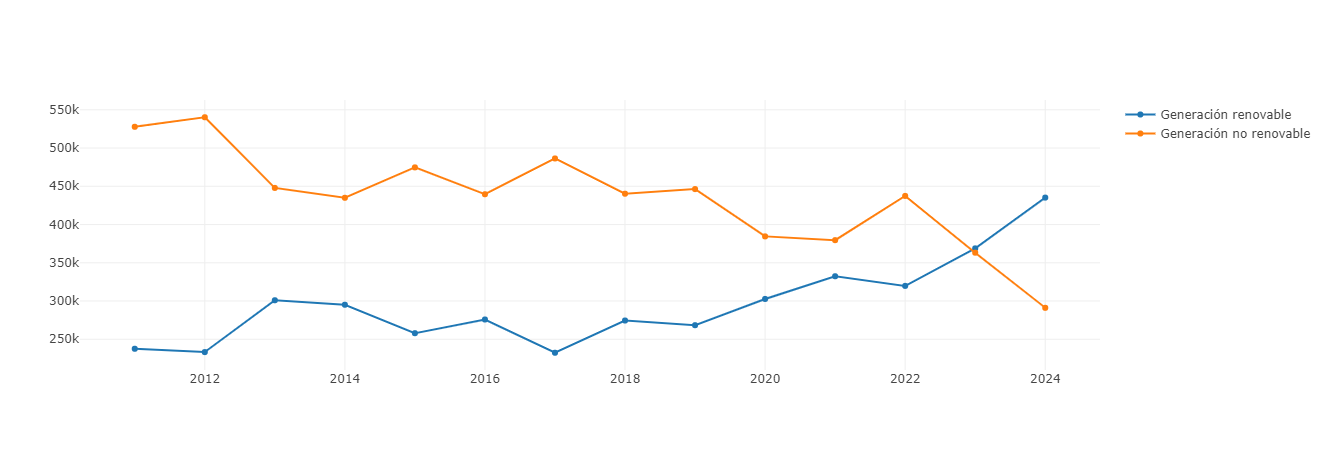

EnergiasParaAnalizar: Seq[String] = List(
  "Generaci\u00f3n renovable",
  "Generaci\u00f3n no renovable"
)

In [21]:
val EnergiasParaAnalizar = Seq("Generación renovable", "Generación no renovable")
AnalisisEnergiasAnual(EnergiasParaAnalizar, dataFrameBalance)

collect at cmd21.sc:15

3 / 3

collect at cmd21.sc:15

8 / 8

collect at cmd21.sc:15

8 / 8

collect at cmd21.sc:15

8 / 8

collect at cmd21.sc:15

8 / 8

collect at cmd21.sc:15

3 / 3

collect at cmd21.sc:15

8 / 8

collect at cmd21.sc:15

8 / 8

collect at cmd21.sc:15

8 / 8

collect at cmd21.sc:15

8 / 8

collect at cmd21.sc:16

3 / 3

collect at cmd21.sc:16

8 / 8

collect at cmd21.sc:16

8 / 8

collect at cmd21.sc:16

8 / 8

collect at cmd21.sc:16

8 / 8

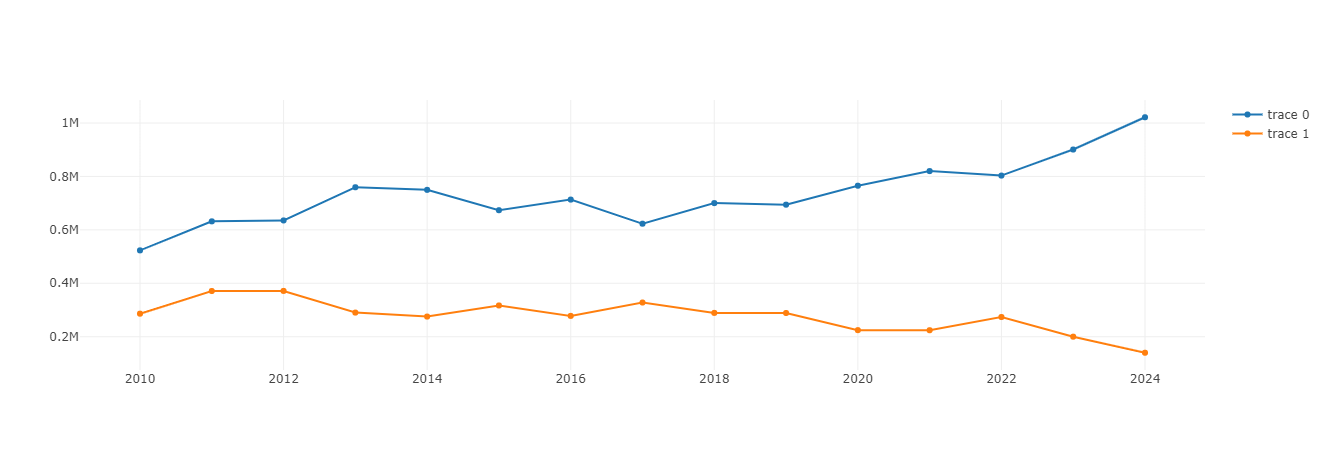

defined function AnalisisGruposEnergias
bajasEmisiones: Seq[String] = List(
  "Residuos renovables",
  "Solar fotovoltaica",
  "Solar t\u00e9rmica",
  "Otras renovables",
  "Nuclear",
  "Hidroe\u00f3lica",
  "Generaci\u00f3n renovable",
  "E\u00f3lica",
  "Hidr\u00e1ulica",
  "Turbinaci\u00f3n bombeo"
)
altasEmisiones: Seq[String] = List(
  "Turbina de gas",
  "Residuos no renovables",
  "Cogeneraci\u00f3n",
  "Motores di\u00e9sel",
  "Carb\u00f3n",
  "Ciclo combinado",
  "Turbina de vapor",
  "Fuel + Gas"
)

In [22]:
def AnalisisGruposEnergias(listaGrupos: Seq[Seq[String]], dataFrameBalance: DataFrame): Unit = {
    
    def valorAnual(df: DataFrame): DataFrame = {
        df.groupBy(col("FechaCompleta"))
          .agg(sum("Valor").as("ValorTotalPorDia"))
          .groupBy(date_format(col("FechaCompleta"), "yyyy").as("Año"))
          .agg(avg("ValorTotalPorDia").as("ValorPromedio"))
          .orderBy("Año")
    }
    
    val listaDf = listaGrupos.map{
        grupo => dataFrameBalance.filter(col("Tipo").isin(grupo:_*))
    }
    val valores = listaDf.map(valorAnual(_))
    val seqValores = valores.map(valor => valor.select("ValorPromedio").as[Double].collect.toSeq)
    val fechas = valores.head.select("Año").as[String].collect.toSeq

    val traces = listaGrupos.zip(seqValores).map { case (nombre, seqValor) =>
        Scatter(fechas, seqValor)
    }

  val data = traces
  plot(data)
}

val bajasEmisiones = Seq(
  "Residuos renovables",
  "Solar fotovoltaica",
  "Solar térmica",
  "Otras renovables",
  "Nuclear",
  "Hidroeólica",
  "Generación renovable",
  "Eólica",
  "Hidráulica",
  "Turbinación bombeo"
)
val altasEmisiones = Seq(
  "Turbina de gas",
  "Residuos no renovables",
  "Cogeneración",
  "Motores diésel",
  "Carbón",
  "Ciclo combinado",
  "Turbina de vapor",
  "Fuel + Gas"
)


AnalisisGruposEnergias(Seq(bajasEmisiones, altasEmisiones), dataFrameBalance)

### Analisis mensual de un año de distintos tipos de energias

collect at cmd23.sc:11

3 / 3

collect at cmd23.sc:11

8 / 8

collect at cmd23.sc:11

8 / 8

collect at cmd23.sc:11

8 / 8

collect at cmd23.sc:12

3 / 3

collect at cmd23.sc:12

8 / 8

collect at cmd23.sc:12

8 / 8

collect at cmd23.sc:12

8 / 8

collect at cmd23.sc:12

3 / 3

collect at cmd23.sc:12

8 / 8

collect at cmd23.sc:12

8 / 8

collect at cmd23.sc:12

8 / 8

collect at cmd23.sc:12

3 / 3

collect at cmd23.sc:12

8 / 8

collect at cmd23.sc:12

8 / 8

collect at cmd23.sc:12

8 / 8

collect at cmd23.sc:12

3 / 3

collect at cmd23.sc:12

8 / 8

collect at cmd23.sc:12

8 / 8

collect at cmd23.sc:12

8 / 8

collect at cmd23.sc:12

3 / 3

collect at cmd23.sc:12

8 / 8

collect at cmd23.sc:12

8 / 8

collect at cmd23.sc:12

8 / 8

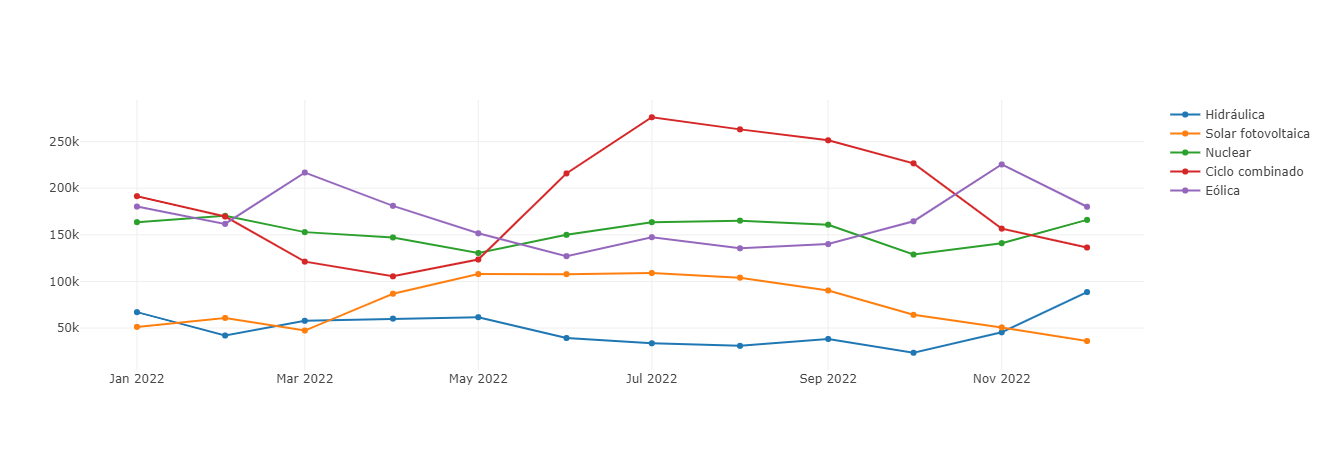

defined function AnalisisEnergiasMensual
dataFrameBalance2024: Dataset[Row] = [Familia: string, Tipo: string ... 6 more fields]
EnergiasParaAnalizar: Seq[String] = List(
  "Hidr\u00e1ulica",
  "Solar fotovoltaica",
  "Nuclear",
  "Ciclo combinado",
  "E\u00f3lica"
)

In [24]:
def AnalisisEnergiasMensual(listaEnergias: Seq[String], df: DataFrame): Unit = {
  // Agrupar y calcular la media para datos renovables
  def calcularMediaMensual(df1: DataFrame, tipo: String): DataFrame = {
    df1.filter(col("Tipo") === tipo)
      .groupBy(date_format(col("FechaCompleta"), "yyyy-MM").as("Mes"))
      .agg(avg("Valor").as("ValorPromedio"))
      .orderBy("Mes")
  }

  val valores = listaEnergias.map(tipoEnergia => calcularMediaMensual(df, tipoEnergia))
  val seqFechas = valores.head.select("Mes").as[String].collect.toSeq
  val seqValores = valores.map(valor => valor.select("ValorPromedio").as[Double].collect.toSeq)

  val traces = listaEnergias.zip(seqValores).map { case (nombre, seqValor) =>
    Scatter(seqFechas, seqValor, name = nombre)
  }

  val data = traces
  plot(data)
}

val dataFrameBalance2024 = dataFrameBalance.filter(date_format(col("FechaCompleta"),"yyyy") === "2022") //Elegimos año
val EnergiasParaAnalizar = Seq("Hidráulica", "Solar fotovoltaica", "Nuclear", "Ciclo combinado", "Eólica")

AnalisisEnergiasMensual(EnergiasParaAnalizar, dataFrameBalance2024)

#### Top 5 tipos de energías por su generación anual

head at cmd26.sc:11

3 / 3

head at cmd26.sc:11

8 / 8

head at cmd26.sc:12

3 / 3

head at cmd26.sc:12

8 / 8

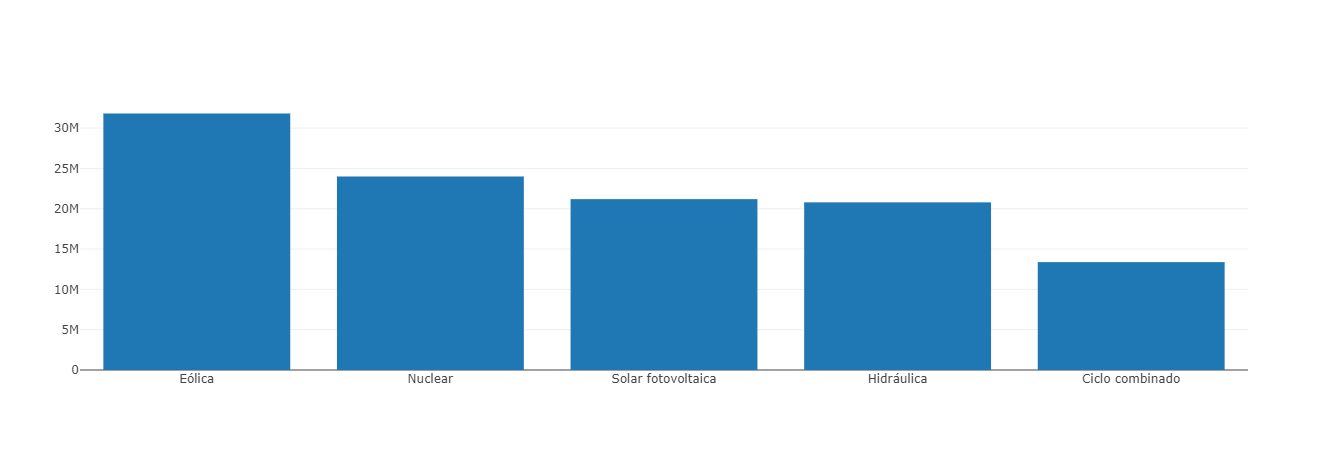

defined function top5anual
res26_1: String = "plot-bc239da4-bea0-4636-8193-0e27442cc849"

In [27]:
def top5anual (Año: Int) = {
val energiasOrdenadas= dataFrameBalance
    .filter(date_format(col("FechaCompleta"),"yyyy") === Año) //Año
    .filter(col("Familia") =!= "Demanda")
    .filter(!col("Tipo").isin("Generación renovable", "Generación no renovable"))
    .groupBy($"Tipo")
    //.groupBy(date_format(col("FechaCompleta"), "yyyy-MM").as("Mes"))
    .agg(sum("Valor").as[Double].as("ValorTotal"))
    .orderBy($"ValorTotal".desc)

val seqValores = energiasOrdenadas.select($"ValorTotal").as[Double].head(5).toSeq
val seqTipo = energiasOrdenadas.select($"Tipo").as[String].head(5).toSeq
val data = Seq(Bar(
    seqTipo,
    seqValores,
))

plot(data)
}
top5anual(2024)